In [1]:
# Adds link to the scripts folder
import sys
import os
sys.path.append("../scripts/")
import matplotlib.pyplot as plt
import numpy as np

from trajectory import Trajectory, create_trajectory_list, create_all_patient_trajectories
from hivevo.patients import Patient
import filenames
import copy

# Mean frequency over time

In [7]:
def get_mean_in_time(trajectories, nb_bins=15, freq_range=[0.4, 0.6]):
    """
    Computes the mean frequency in time of a set of trajectories from the point they are seen in the freq_range window.
    Returns the middle of the time bins and the computed frequency mean.
    """
    # Create bins and select trajectories going through the freq_range
    time_bins = np.linspace(-1000, 2000, nb_bins)
    trajectories = [traj for traj in trajectories if np.sum(np.logical_and(
        traj.frequencies >= freq_range[0], traj.frequencies < freq_range[1]), dtype=bool)]

    # Offset trajectories to set t=0 at the point they are seen in the freq_range and adds all the frequencies / times
    # to arrays for later computation of mean
    t_traj = np.array([])
    f_traj = np.array([])
    for traj in trajectories:
        idx = np.where(np.logical_and(traj.frequencies >=
                                      freq_range[0], traj.frequencies < freq_range[1]))[0][0]
        traj.t = traj.t - traj.t[idx]
        t_traj = np.concatenate((t_traj, traj.t))
        f_traj = np.concatenate((f_traj, traj.frequencies))

    # Binning of all the data in the time bins
    filtered_fixed = [traj for traj in trajectories if traj.fixation == "fixed"]
    filtered_lost = [traj for traj in trajectories if traj.fixation == "lost"]
    freqs, fixed, lost = [], [], []
    for ii in range(len(time_bins) - 1):
        freqs = freqs + [f_traj[np.logical_and(t_traj >= time_bins[ii], t_traj < time_bins[ii + 1])]]
        fixed = fixed + [len([traj for traj in filtered_fixed if traj.t[-1] < time_bins[ii]])]
        lost = lost + [len([traj for traj in filtered_lost if traj.t[-1] < time_bins[ii]])]

    # Computation of the mean in each bin, active trajectories contribute their current frequency,
    # fixed contribute 1 and lost contribute 0
    mean = []
    for ii in range(len(freqs)):
        mean = mean + [np.sum(freqs[ii]) + fixed[ii]]
        mean[-1] /= (len(freqs[ii]) + fixed[ii] + lost[ii])

    return 0.5 * (time_bins[1:] + time_bins[:-1]), mean

def split_traj_fitness(trajectories, median):
    traj_low = [traj for traj in trajectories if traj.fitness < median]
    traj_high = [traj for traj in trajectories if traj.fitness >= median]
    return traj_low, traj_high

## Frequency in time for low vs high fitness

In [8]:
region = "env"
trajectories_env = create_all_patient_trajectories(region)
trajectories_env = [traj for traj in trajectories_env if traj.t[-1] != 0] 
fitness_median_env = np.nanmean([traj.fitness for traj in trajectories_env])
print(f"Fitness median for env : {fitness_median_env}")

region = "pol"
trajectories_pol = create_all_patient_trajectories(region)
trajectories_pol = [traj for traj in trajectories_pol if traj.t[-1] != 0] 
fitness_median_pol = np.nanmean([traj.fitness for traj in trajectories_pol])
print(f"Fitness median for pol : {fitness_median_pol}")

region = "gag"
trajectories_gag = create_all_patient_trajectories(region)
trajectories_gag = [traj for traj in trajectories_gag if traj.t[-1] != 0] 
fitness_median_gag = np.nanmean([traj.fitness for traj in trajectories_gag])
print(f"Fitness median for gag : {fitness_median_gag}")


traj_env_low, traj_env_high = split_traj_fitness(trajectories_env, fitness_median_env)
traj_pol_low, traj_pol_high = split_traj_fitness(trajectories_pol, fitness_median_pol)
traj_gag_low, traj_gag_high = split_traj_fitness(trajectories_gag, fitness_median_gag)

Fitness median for env : 0.11618917610710608
Fitness median for pol : 0.02660548999393572
Fitness median for gag : 0.049333446191052


## Region env

In [24]:
def mean_low_vs_high(traj_low, traj_high, freq_range): 
    nb_bins = 15
    fontsize = 16
    time_bins, mean_low = get_mean_in_time(traj_low, nb_bins, freq_range)
    time_bins, mean_high= get_mean_in_time(traj_high, nb_bins, freq_range)
    return time_bins, mean_low, mean_high

freq_range = [0.2, 0.4]
time_bins, mean_env_low1, mean_env_high1 = mean_low_vs_high(traj_env_low, traj_env_high, freq_range)

freq_range = [0.4, 0.6]
time_bins, mean_env_low2, mean_env_high2 = mean_low_vs_high(traj_env_low, traj_env_high, freq_range)

freq_range = [0.6, 0.8]
time_bins, mean_env_low3, mean_env_high3 = mean_low_vs_high(traj_env_low, traj_env_high, freq_range)

freq_range = [0.1,0.9]
time_bins, mean_env_low_all, mean_env_high_all = mean_low_vs_high(traj_env_low, traj_env_high, freq_range)

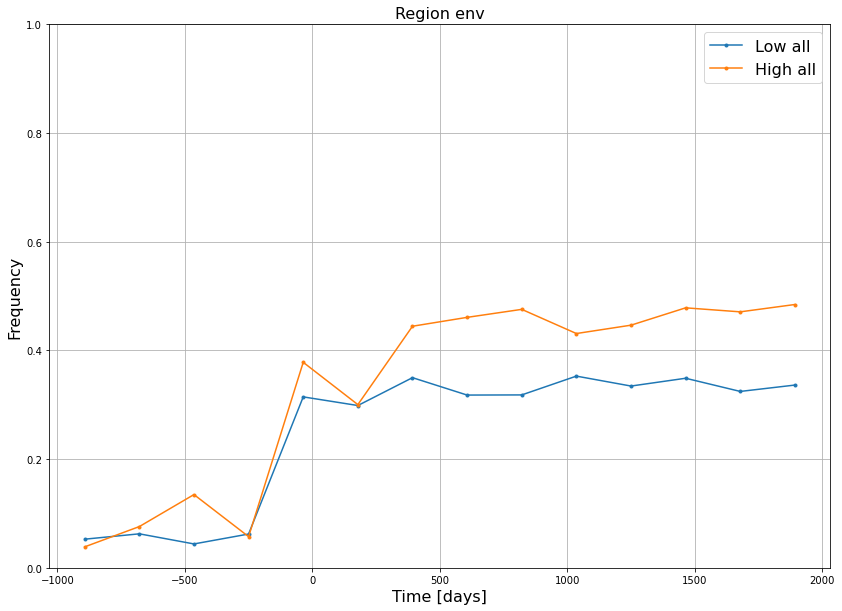

In [25]:
fontsize=16

plt.figure(figsize=(14,10))
plt.plot(time_bins, mean_env_low_all, '.-', label="Low all")
plt.plot(time_bins, mean_env_high_all, '.-', label="High all")
plt.xlabel("Time [days]", fontsize=fontsize)
plt.ylabel("Frequency", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.title(f"Region env", fontsize=fontsize)
plt.ylim([0,1])
plt.grid()
plt.show()

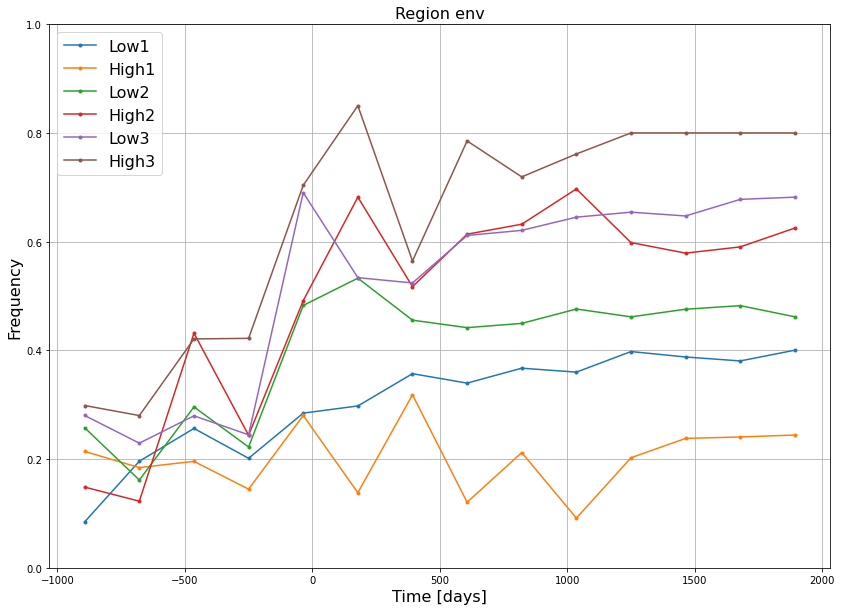

In [18]:
fontsize=16

plt.figure(figsize=(14,10))
plt.plot(time_bins, mean_env_low1, '.-', label="Low1")
plt.plot(time_bins, mean_env_high1, '.-', label="High1")
plt.plot(time_bins, mean_env_low2, '.-', label="Low2")
plt.plot(time_bins, mean_env_high2, '.-', label="High2")
plt.plot(time_bins, mean_env_low3, '.-', label="Low3")
plt.plot(time_bins, mean_env_high3, '.-', label="High3")
plt.xlabel("Time [days]", fontsize=fontsize)
plt.ylabel("Frequency", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.title(f"Region env", fontsize=fontsize)
plt.ylim([0,1])
plt.grid()
plt.show()

## Region pol

In [26]:
freq_range = [0.2, 0.4]
time_bins, mean_pol_low1, mean_pol_high1 = mean_low_vs_high(traj_pol_low, traj_pol_high, freq_range)

freq_range = [0.4, 0.6]
time_bins, mean_pol_low2, mean_pol_high2 = mean_low_vs_high(traj_pol_low, traj_pol_high, freq_range)

freq_range = [0.6, 0.8]
time_bins, mean_pol_low3, mean_pol_high3 = mean_low_vs_high(traj_pol_low, traj_pol_high, freq_range)

freq_range = [0.1,0.9]
time_bins, mean_pol_low_all, mean_pol_high_all = mean_low_vs_high(traj_pol_low, traj_pol_high, freq_range)

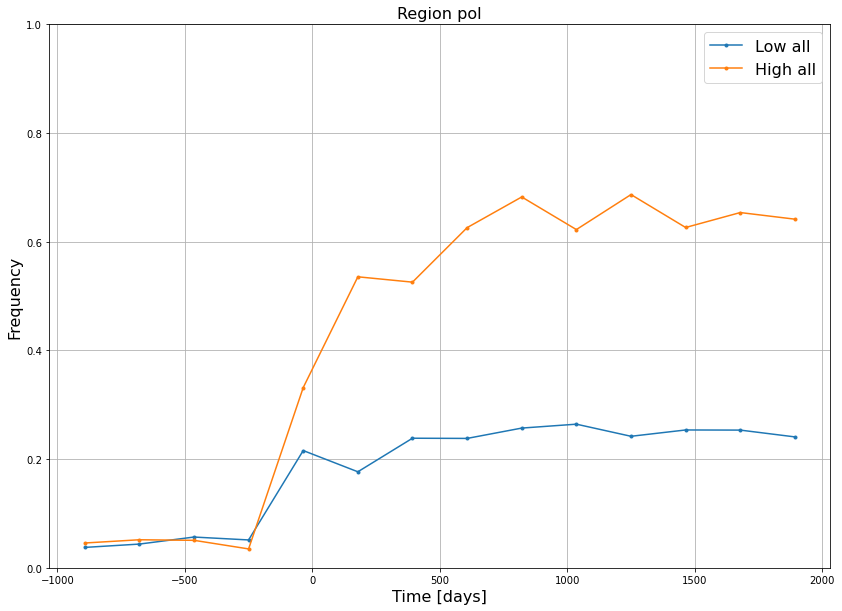

In [28]:
fontsize=16

plt.figure(figsize=(14,10))
plt.plot(time_bins, mean_pol_low_all, '.-', label="Low all")
plt.plot(time_bins, mean_pol_high_all, '.-', label="High all")
plt.xlabel("Time [days]", fontsize=fontsize)
plt.ylabel("Frequency", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.title(f"Region pol", fontsize=fontsize)
plt.ylim([0,1])
plt.grid()
plt.show()

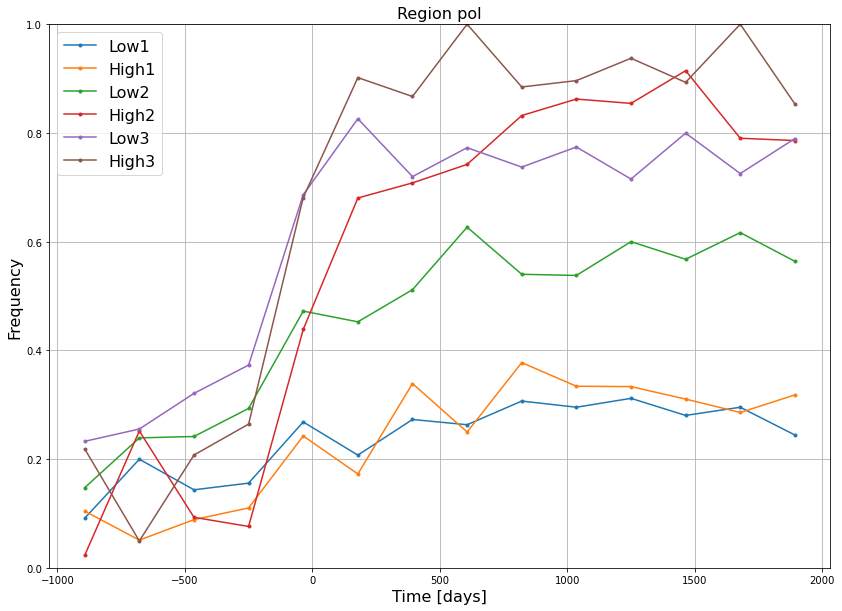

In [29]:
fontsize=16

plt.figure(figsize=(14,10))
plt.plot(time_bins, mean_pol_low1, '.-', label="Low1")
plt.plot(time_bins, mean_pol_high1, '.-', label="High1")
plt.plot(time_bins, mean_pol_low2, '.-', label="Low2")
plt.plot(time_bins, mean_pol_high2, '.-', label="High2")
plt.plot(time_bins, mean_pol_low3, '.-', label="Low3")
plt.plot(time_bins, mean_pol_high3, '.-', label="High3")
plt.xlabel("Time [days]", fontsize=fontsize)
plt.ylabel("Frequency", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.title(f"Region pol", fontsize=fontsize)
plt.ylim([0,1])
plt.grid()
plt.show()

## Region gag

In [30]:
freq_range = [0.2, 0.4]
time_bins, mean_gag_low1, mean_gag_high1 = mean_low_vs_high(traj_gag_low, traj_gag_high, freq_range)

freq_range = [0.4, 0.6]
time_bins, mean_gag_low2, mean_gag_high2 = mean_low_vs_high(traj_gag_low, traj_gag_high, freq_range)

freq_range = [0.6, 0.8]
time_bins, mean_gag_low3, mean_gag_high3 = mean_low_vs_high(traj_gag_low, traj_gag_high, freq_range)

freq_range = [0.1,0.9]
time_bins, mean_gag_low_all, mean_gag_high_all = mean_low_vs_high(traj_gag_low, traj_gag_high, freq_range)

<ipython-input-7-69f43fce165b>:36: RuntimeWarning: invalid value encountered in double_scalars
  mean[-1] /= (len(freqs[ii]) + fixed[ii] + lost[ii])


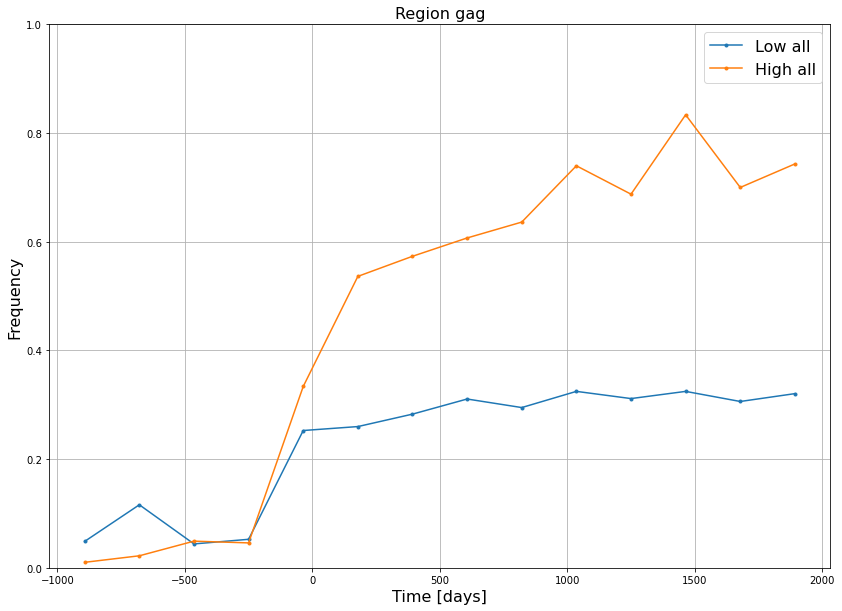

In [31]:
fontsize=16

plt.figure(figsize=(14,10))
plt.plot(time_bins, mean_gag_low_all, '.-', label="Low all")
plt.plot(time_bins, mean_gag_high_all, '.-', label="High all")
plt.xlabel("Time [days]", fontsize=fontsize)
plt.ylabel("Frequency", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.title(f"Region gag", fontsize=fontsize)
plt.ylim([0,1])
plt.grid()
plt.show()

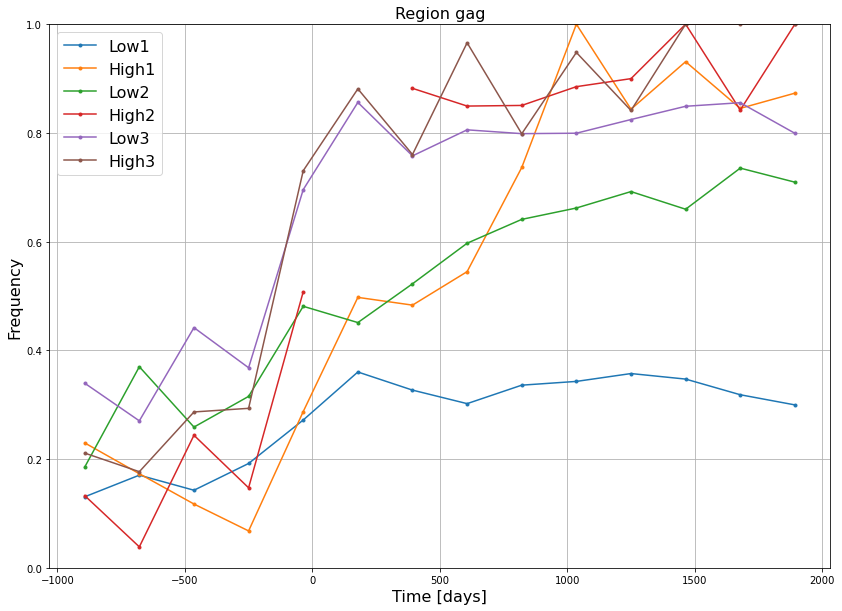

In [32]:
fontsize=16

plt.figure(figsize=(14,10))
plt.plot(time_bins, mean_gag_low1, '.-', label="Low1")
plt.plot(time_bins, mean_gag_high1, '.-', label="High1")
plt.plot(time_bins, mean_gag_low2, '.-', label="Low2")
plt.plot(time_bins, mean_gag_high2, '.-', label="High2")
plt.plot(time_bins, mean_gag_low3, '.-', label="Low3")
plt.plot(time_bins, mean_gag_high3, '.-', label="High3")
plt.xlabel("Time [days]", fontsize=fontsize)
plt.ylabel("Frequency", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.title(f"Region gag", fontsize=fontsize)
plt.ylim([0,1])
plt.grid()
plt.show()

## Comparison between regions

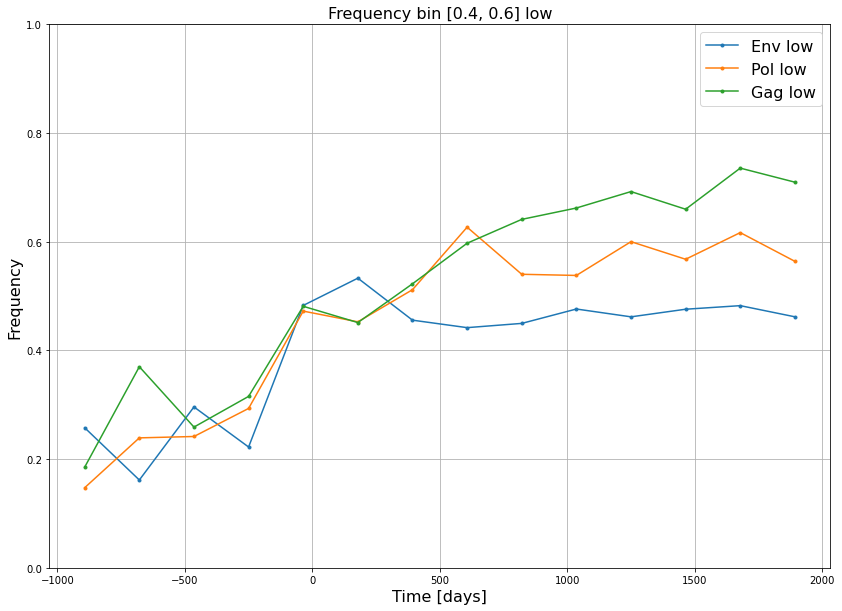

In [35]:
plt.figure(figsize=(14,10))
plt.plot(time_bins, mean_env_low2, '.-', label="Env low")
plt.plot(time_bins, mean_pol_low2, '.-', label="Pol low")
plt.plot(time_bins, mean_gag_low2, '.-', label="Gag low")
plt.xlabel("Time [days]", fontsize=fontsize)
plt.ylabel("Frequency", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.title(f"Frequency bin [0.4, 0.6] low", fontsize=fontsize)
plt.ylim([0,1])
plt.grid()
plt.show()

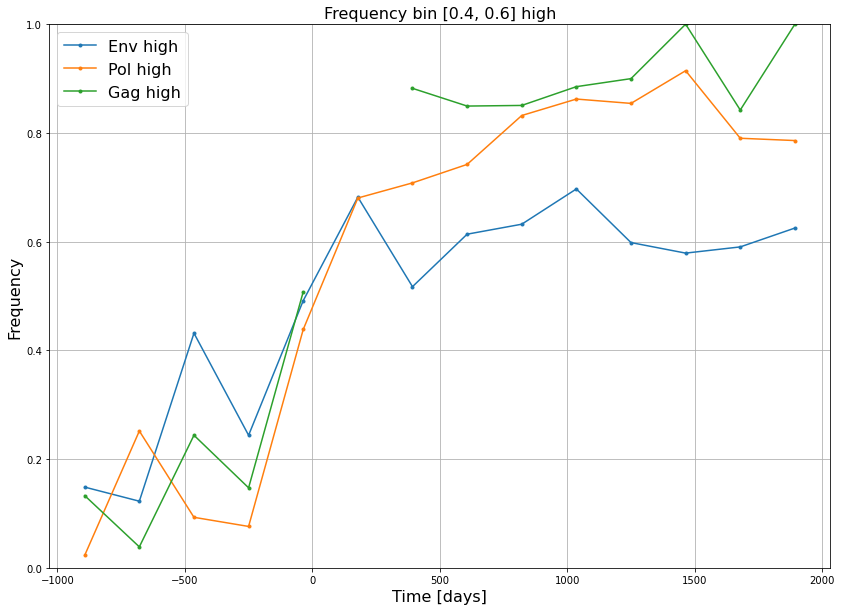

In [34]:
plt.figure(figsize=(14,10))
plt.plot(time_bins, mean_env_high2, '.-', label="Env high")
plt.plot(time_bins, mean_pol_high2, '.-', label="Pol high")
plt.plot(time_bins, mean_gag_high2, '.-', label="Gag high")
plt.xlabel("Time [days]", fontsize=fontsize)
plt.ylabel("Frequency", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.title(f"Frequency bin [0.4, 0.6] high", fontsize=fontsize)
plt.ylim([0,1])
plt.grid()
plt.show()